In [3]:
import numpy as np
from torch.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt
import torch
import tqdm
print(torch.__version__)

pi = torch.pi

def rgb2gray(u):
    return 0.2989 * u[:,:,0] + 0.5870 * u[:,:,1] + 0.1140 * u[:,:,2]

def str2(chars):
    return "{:.2f}".format(chars)

def psnr(uref,ut,M=1):
    mse = np.sqrt(np.mean((np.array(uref)-np.array(ut))**2))
    return 20*np.log10(M/mse)

def optim(f, image_shape, niter=1000,lr=0.1):
    M,N = image_shape
    u = torch.randn(M,N, requires_grad=True)
    # optimu = torch.optim.SGD([u], lr=lr)
    optimu = torch.optim.Adam([u], lr=lr)
    losslist = []
    for it in range(niter):
        loss = f(u)
        losslist.append(loss.detach())
        optimu.zero_grad()
        loss.backward()
        optimu.step()
    return u.detach(),losslist

# viewimage
import tempfile
import IPython
from skimage.transform import rescale

def viewimage(im, normalize=True,z=2,order=0,titre='',displayfilename=False):
    imin= np.array(im).copy().astype(np.float32)
    imin = rescale(imin, z, order=order)
    if normalize:
        imin-=imin.min()
        if imin.max()>0:
            imin/=imin.max()
    else:
        imin=imin.clip(0,255)/255
    imin=(imin*255).astype(np.uint8)
    filename=tempfile.mktemp(titre+'.png')
    if displayfilename:
        print (filename)
    plt.imsave(filename, imin, cmap='gray')
    IPython.display.display(IPython.display.Image(filename))

# alternative viewimage if the other one does not work:
def Viewimage(im,dpi=100,cmap='gray'):
    plt.figure(dpi=dpi)
    if cmap is None:
        plt.imshow(np.array(im))
    else:
        plt.imshow(np.array(im),cmap=cmap)
    plt.axis('off')
    plt.show()

# !wget https://perso.telecom-paristech.fr/aleclaire/mva/tpdeblur.zip
# !unzip tpdeblur.zip

2.2.1


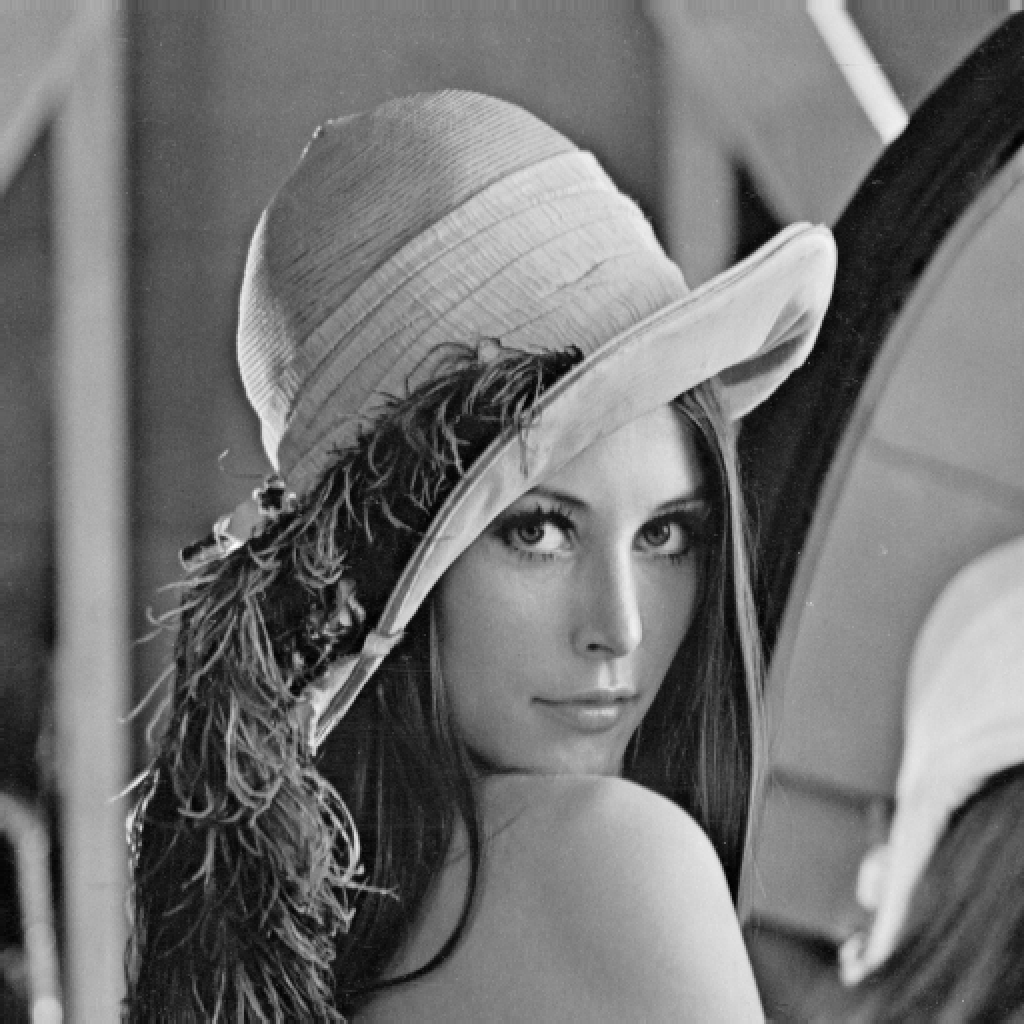

In [4]:
# Open the image
x = torch.tensor(rgb2gray(plt.imread('im/lena_color.png')))
M,N = x.shape

viewimage(x)

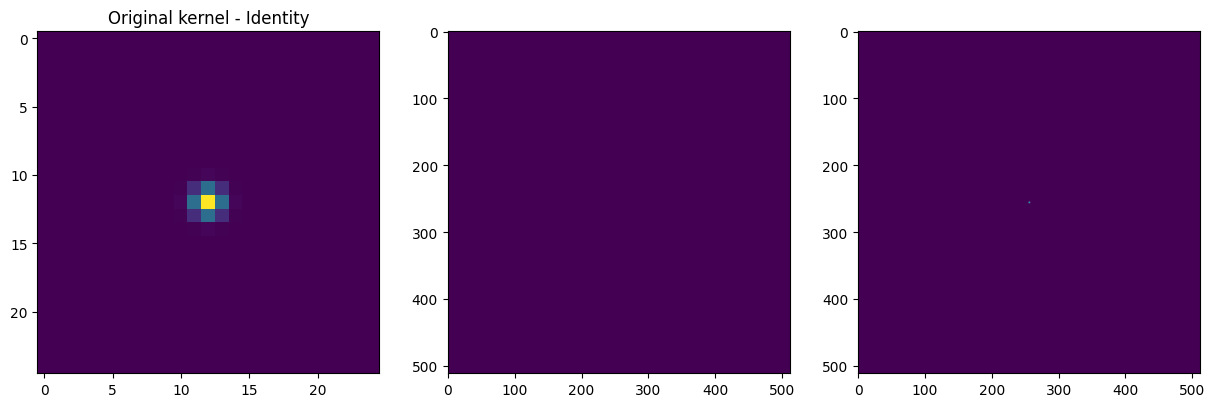

In [5]:
kt = torch.tensor(np.loadtxt('kernels/kernel0.txt'))
(m,n) = kt.shape
# kt = torch.zeros((m,n))
# kt[12,12] = 1

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(kt)
ax[0].set_title('Original kernel - Identity')

# Embed the kernel in a MxN image, and put center at pixel (0,0)
k = torch.zeros((M,N))
k[0:m,0:n] = kt/torch.sum(kt)
k = torch.roll(k,(-int(m/2),-int(n/2)),(0,1)) # periodic translation
ax[1].imshow(k)
ax[2].imshow(fftshift(k))
plt.show()

fk = fft2(k)

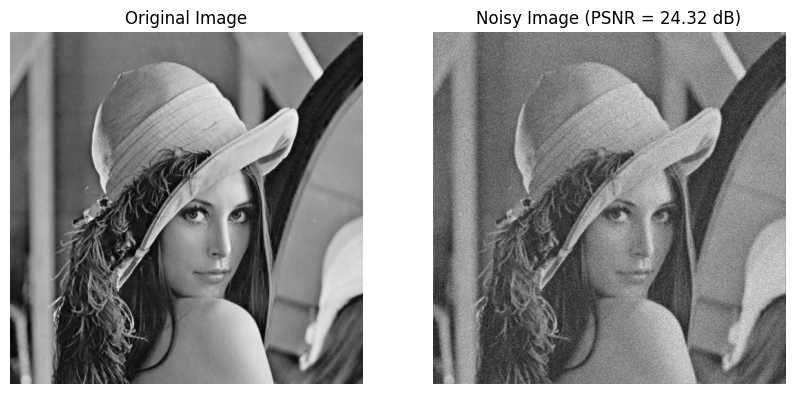

In [6]:
# Degraded image

sigma = 15. / 255.

def forward_operator(x, k):
    """Compute the forward operator Kx = k * x, where k is the convolution kernel.
    ----------------
    x: torch.Tensor
        The input image.
    k: torch.Tensor
        The convolution kernel.
    """
    return ifft2(fft2(k) * fft2(x)).real


z = forward_operator(x, k) + torch.randn((M, N)) * sigma
# z = x + torch.randn((M, N)) * sigma

fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=100)
ax[0].imshow(x,cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(z,cmap='gray')
ax[1].set_title('Noisy Image (PSNR = ' + str2(psnr(x,z)) + ' dB)')
ax[1].axis('off')
plt.show()

In [7]:
# Function for smoothed TV norm
def smoothed_TV(x, eps=1e-3):
    """Compute the smoothed total variation norm of x.
    -------------------
    Parameters:
    x: torch.Tensor
        Image to compute the TV norm of.
    eps: float
        Smoothing parameter.
    """
    d1x = torch.roll(x, -1, 0) - x
    d2x = torch.roll(x, -1, 1) - x
    Dx = torch.sqrt(torch.square(d1x) + torch.square(d2x) + eps**2)
    return torch.sum(Dx)

In [8]:
def regularization(x, lambda_, eps=1e-3):
    """Compute the regularization term (- log p(x)) of x.
    -------------------
    Parameters:
    x: torch.Tensor
        Image to compute the regularization term of.
    """
    return smoothed_TV(x, eps) / lambda_
    # return smoothed_TV(x, eps) * lambda_

In [9]:
def data_fidelity(z, x, sigma):
    """Compute the data fidelity term (- log p(z|x)) of z.
    -------------------
    Parameters:
    z: torch.Tensor
        Image to compute the data fidelity term of.
    x: torch.Tensor
        Original image.
    sigma: float
        Noise level.
    """
    norm = torch.linalg.vector_norm(forward_operator(x, k) - z)
    # norm = torch.norm(forward_operator(x, k) - z)
    # return 0.5 * torch.square(norm)
    return 0.5 * torch.square(norm) / sigma**2

In [10]:
def energy_functional(x, z, lambda_, sigma=sigma, eps=1e-3):
    """Compute the energy functional of x.
    -------------------
    Parameters:
    x: torch.Tensor
        Original image.
    z: torch.Tensor
        Noisy image.
    lambda_: float
        Regularization parameter.
    sigma: float
        Noise level.
    eps: float
        Smoothing parameter.
    """
    return regularization(x, lambda_) + data_fidelity(z, x, sigma)

In [11]:
def MAP(x, z, lambda_, sigma=sigma, eps=1e-3, lr=1e-2, niter=1000):
    """Compute the Maximum A Posteriori estimate of x.
    -------------------
    Parameters:
    x: torch.Tensor
        Original image.
    z: torch.Tensor
        Noisy image.
    lambda_: float
        Regularization parameter.
    sigma: float
        Noise level.
    eps: float
        Smoothing parameter.
    """
    E = lambda u: energy_functional(u, z, lambda_, sigma, eps)
    return optim(E, (M,N), niter=niter, lr=lr)

In [12]:
# Hyperparameters (adjust these as needed)
lam = 0.15
lr = 1.9 / (1 + 16 * (1/lam))  # 1.9 so that < to 2/L (L = 1+16*lambda)
# lr = 1e-3

# Denoised image with smoothed-TV regularization
xtvs, losslist = MAP(x, z, lambda_=lam, lr=lr, niter=1000)


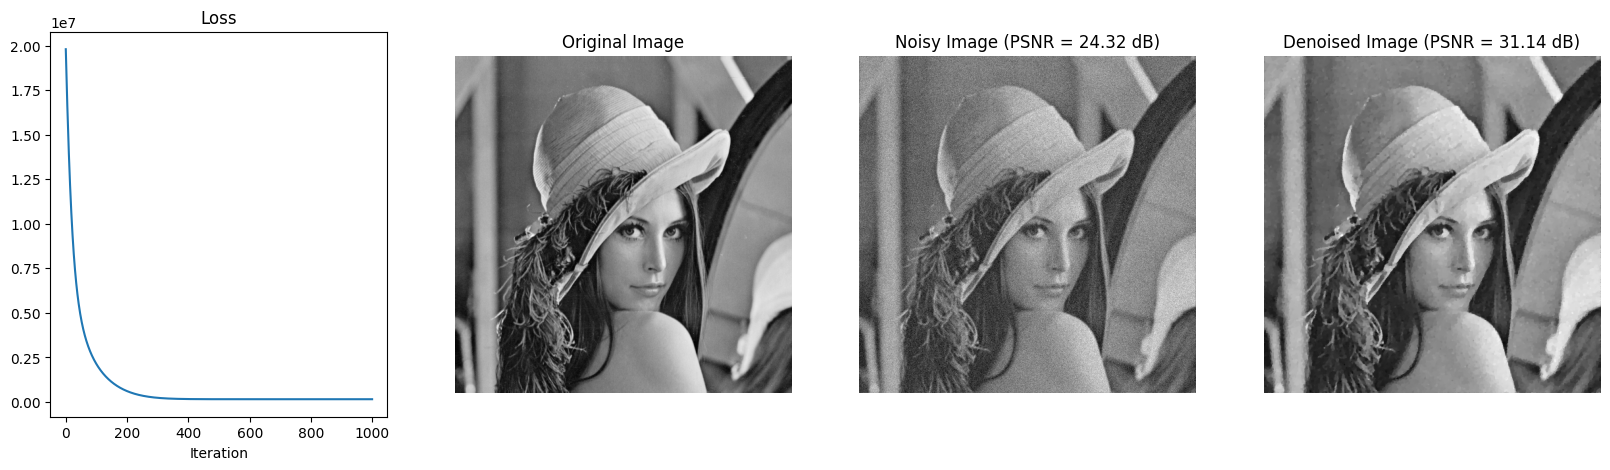

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20,5), dpi=100)
ax[0].plot(losslist)
ax[0].set_title('Loss')
ax[0].set_xlabel('Iteration')
ax[1].imshow(x, cmap='gray')
ax[1].set_title('Original Image')
ax[1].axis('off')
ax[2].imshow(z, cmap='gray')
ax[2].set_title('Noisy Image (PSNR = ' + str2(psnr(x, z)) + ' dB)')
ax[2].axis('off')
ax[3].imshow(xtvs, cmap='gray')
ax[3].set_title('Denoised Image (PSNR = ' + str2(psnr(x, xtvs)) + ' dB)')
ax[3].axis('off')
plt.show()

In [20]:
def unadjusted_langevin_dynamics(z, lambda_=0.15, sigma=sigma, eps=1e-3, tau=1e-4, niter=2000):
    """Compute a sequence of iterates of x using ULA.
    -------------------
    Parameters:
    x0: torch.Tensor
        Starting point of the chain.
    z: torch.Tensor
        Noisy image.
    lambda_: float
        Regularization parameter.
    sigma: float
        Noise level.
    eps: float
        Smoothing parameter.
    """
    burn_in = max(int(0.9 * niter), niter - 1000)
    early_stopping = 1e-2
    E = lambda u: energy_functional(u, z, lambda_, sigma, eps)
    x_t = torch.randn(M, N, requires_grad=True)
    energies = []
    chain_iterates = []
    for it in tqdm.tqdm(range(niter)):
        energy = E(x_t)
        energies.append(energy.detach())
        grad = torch.autograd.grad(energy, x_t)[0]
        x_t = x_t - tau * grad + torch.randn(M, N) * np.sqrt(2 * tau)
        x_t = x_t.detach().requires_grad_(True)
        if it > burn_in and it % 2 == 0:
            chain_iterates.append(x_t.detach())
        if len(chain_iterates) > 2 and torch.linalg.vector_norm(chain_iterates[-1] - chain_iterates[-2]) < early_stopping:
            print(f'Early stopping at iteration {it}')
            break
    return energies, chain_iterates

In [30]:
def MMSE(chain_iterates):
    """Compute the MMSE estimate of the chain iterates.
    -------------------
    Parameters:
    chain_iterates: List[torch.Tensor]
        List of chain iterates.
    """
    return torch.mean(torch.stack(chain_iterates), dim=0)


def posterior_variance(chain_iterates):
    """Compute the posterior variance of the chain iterates.
    -------------------
    Parameters:
    chain_iterates: List[torch.Tensor]
        List of chain iterates.
    """
    return torch.var(torch.stack(chain_iterates), dim=0)

100%|██████████| 2000/2000 [00:22<00:00, 87.25it/s]


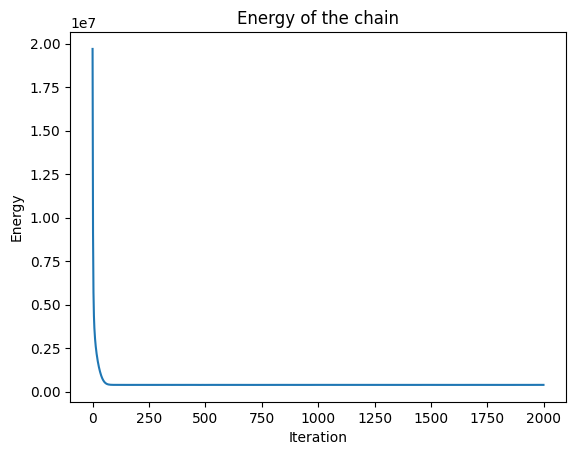

In [22]:
# Test unadjusted Langevin dynamics

energies, chain_iterates = unadjusted_langevin_dynamics(z, lambda_=lam, eps=1e-3, tau=1e-3, niter=2000)

plt.plot(energies)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Energy of the chain')
plt.show()

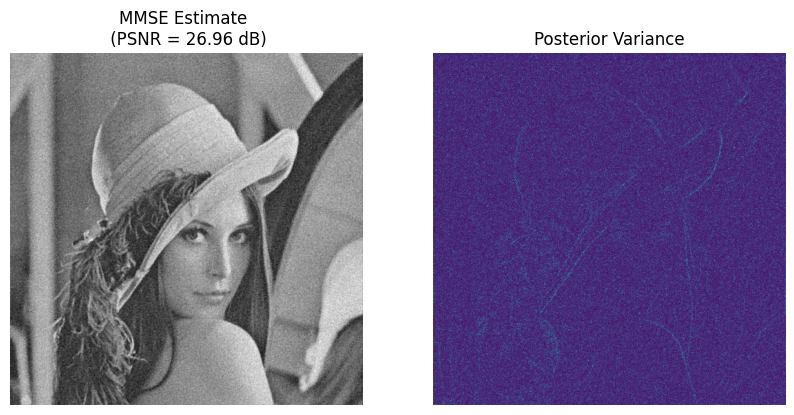

In [31]:
MMSE_estimator = MMSE(chain_iterates)
posterior_variance_estimator = posterior_variance(chain_iterates)

fig, ax = plt.subplots(1, 2, figsize=(10,5), dpi=100)
ax[0].imshow(MMSE_estimator, cmap='gray')
ax[0].set_title('MMSE Estimate \n (PSNR = ' + str2(psnr(x, MMSE_estimator)) + ' dB)')
ax[0].axis('off')
ax[1].imshow(posterior_variance_estimator)
ax[1].set_title('Posterior Variance')
ax[1].axis('off')
plt.show()